<h1><center><i>ROSSMANN STORE SALES PREDICTION</i></center></h1>

<h2> 1. Problem Description </h2>

Rossman Operates over 3000 Drug stores in 7 European Countries. Currently, Rossman store managers are tasked with predicting their daily sales for next six weeks in advance. Store Sales are infulenced by many factors including promotions, competition,school and state holidays, seasonality and locality. With Thousands of individual managers predicting sales based on their unique characteristics , the accuracy of results can be quite varied

We are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

<h2> 2. Real World/Business Objective and Constraints </h2>

1. The cost of a mis-prediction can be high.
2. No strict latency concerns.
3. Interpretability is partially important.

<h2> 3. Data </h2>

- train.csv - historical data including Sales
- test.csv  - historical data  excluding Sales
- store.csv - Supplemental information about the stores

<h2> 4. Data Fields </h2>

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

<h2> 5. Mapping the real world problem to an ML problem </h2>

<h4> <i>5.1 Type of Machine Learning Problem  </i></h4>

It is Time-series forecasting problem, for a given historical data of Store sales we need to predict the furture sales. We will convert it to Supervised Regression Machine Learning Problem

<h4> <i> 5.2 Performance Metric </i> </h4>

RMSPE (ROOT MEAN SQUARE PERCENTAGE ERROR)

In [3]:
Image(url= "https://i.stack.imgur.com/o9qfA.png", width=300, height=300)

where y_i denotes the sales of a single store on a single day and yhat_i denotes the corresponding prediction. Any day and store with 0 sales is ignored.

<h2> 6. Exploratory Data Analysis </h2>

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from IPython.display import Image
from IPython.core.display import HTML 

In [308]:
mydateparse = lambda dt: pd.to_datetime(dt,format='%Y-%m-%d')

In [309]:
# Train Data
train_df = pd.read_csv('train.csv',parse_dates=['Date'],
                      date_parser=mydateparse)

# Test Data
test_df = pd.read_csv('test.csv',parse_dates=['Date'],
                     date_parser=mydateparse)

# Store Data
store_df = pd.read_csv('store.csv')

#store_states Data
df_store_states = pd.read_csv("store_states.csv")

In [310]:
# Getting the information of Train Data
print("Train Dataset : ",train_df.shape)
print("-"*20+'\n')
train_df.info()

Train Dataset :  (1017209, 9)
--------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [311]:
# Getting the information of Store Data
print("Store Dataset : ",store_df.shape)
print("-"*20+'\n')
store_df.info()

Store Dataset :  (1115, 10)
--------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


- Observation:
    - There are 1017209 datapoints and 9 features in our train dataset and Sales is our Target Column 
    - There are 1115 datapoints and 9 features in Store Dataset
    - There are NULL values in 5 features (CompetitionOpenSinceMonth,
    CompetitionOpenSinceYear,
    Promo2SinceWeek,Promo2SinceYear,PromoInterval)

# Store Open

<AxesSubplot:xlabel='Open', ylabel='count'>

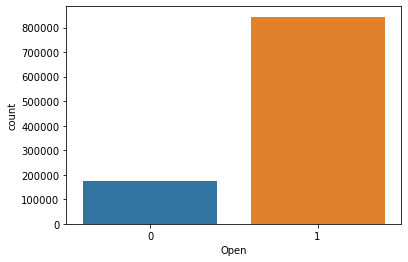

In [312]:
sns.countplot(train_df['Open'])

In [313]:
print("Total Number of days stores closed : ",train_df['Open'].value_counts()[0])
print("Total Number of days stores Open : ",train_df['Open'].value_counts()[1])
print("Percentage of days Store open :",(train_df['Open'].value_counts()[1]/train_df.shape[0])*100,"%")
print("Percentage of days Store Closed :",(train_df['Open'].value_counts()[0]/train_df.shape[0])*100,"%")

Total Number of days stores closed :  172817
Total Number of days stores Open :  844392
Percentage of days Store open : 83.01066939045958 %
Percentage of days Store Closed : 16.989330609540417 %


# Promo

<AxesSubplot:title={'center':'Promo vs Customers'}, xlabel='Promo', ylabel='Customers'>

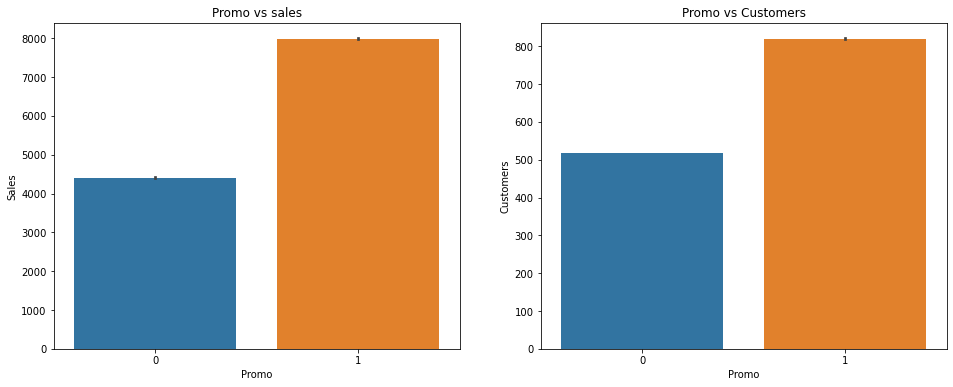

In [314]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.title.set_text("Promo vs sales")
ax2.title.set_text("Promo vs Customers")
sns.barplot(x='Promo',y='Sales',data=train_df,ax=ax1)
sns.barplot(x='Promo',y='Customers',data=train_df,ax=ax2)

- Observation

    - We are observe that Promo has significant impact on Sales and Customer increase. This shows Promo has positive impact for a store

In [315]:
# Extracting some features from data for analysis
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Day'] = train_df['Date'].dt.day
train_df['WeekofYear'] = train_df.Date.dt.weekofyear

In [316]:
train_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31


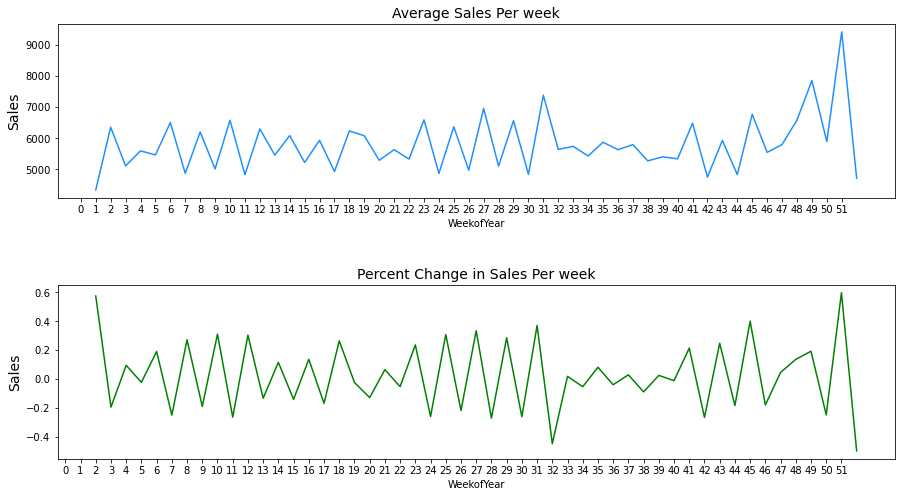

In [317]:
# Calculating the Average Sales and Percent Change in Sales per week
average_sales =train_df.groupby('WeekofYear')['Sales'].mean()
avg_sale_df = pd.DataFrame(average_sales)
percent_change_sales = train_df.groupby("WeekofYear")['Sales'].sum().pct_change()
percent_chng_sale_df = pd.DataFrame(percent_change_sales)



fig, ax = plt.subplots(2,1,figsize=(15,8))

#Plot average Sales
sns.lineplot(x=average_sales_df.index, y=average_sales_df.Sales,ax = ax[0],color='dodgerblue')
ax[0].set_xticks(range(len(average_sales)))
ax[0].set_title("Average Sales Per week", fontsize=14)
ax[0].set_ylabel(ylabel = 'Sales', fontsize=14)


sns.lineplot(x=percent_chng_sale_df.index, y=percent_chng_sale_df.Sales,ax = ax[1],color='green')
ax[1].set_xticks(range(len(percent_change_sales)))
ax[1].set_title("Percent Change in Sales Per week", fontsize=14)
ax[1].set_ylabel(ylabel = 'Sales', fontsize=14)

plt.subplots_adjust(hspace=0.5)

- **Observation**
    - We can observe that Sales are at peak during the December and decrease afterwards;
This is may due to Christmas/Holiday season as most of the people tend to buy beauty products (Rossman manufactures Beauty products) as they go out to celebrate the festival

# Stores Open/Closed

array([[<AxesSubplot:title={'center':'DayOfWeek'}>]], dtype=object)

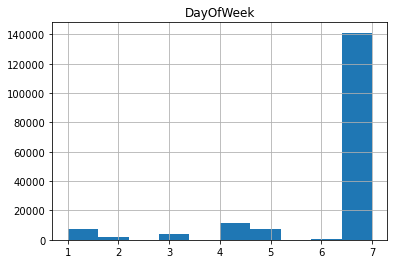

In [318]:
# Days where stores are closed
train_df_store_closed = train_df[train_df.Open == 0]
train_df_store_closed.hist('DayOfWeek')

- **Observations**
    - The above graph clearly indicates that most of the stores remain closed
    on Sundays. Some Stores were closed in weekdays too, It could be due to Stateholidays

# Day of week sales

<AxesSubplot:xlabel='DayOfWeek', ylabel='Customers'>

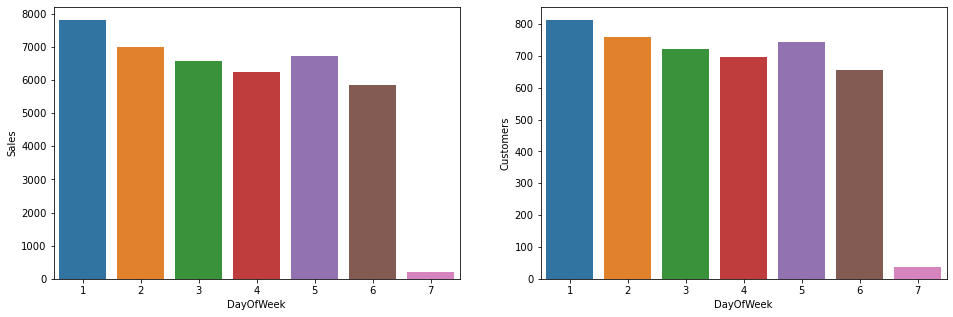

In [319]:
sales_day_wise = train_df.groupby("DayOfWeek")['Sales'].mean()
sales_day_wise_df = pd.DataFrame(sales_day_wise)

customer_day_wise =train_df.groupby("DayOfWeek")['Customers'].mean()
customer_day_wise_df = pd.DataFrame(customer_day_wise)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
sns.barplot(x=sales_day_wise_df.index,y=sales_day_wise_df.Sales,ax=ax1)
sns.barplot(x=customer_day_wise_df.index,y=customer_day_wise_df.Customers,ax=ax2)

- **Observations**
    - The bar graph clearly indicated that Sales and customers both are less on Sundays as most of the stores are closed on Sunday
    - Also, Sales are highest on Monday.This might be due to fact that store are closed on Sundays

# State and School Holiday

<AxesSubplot:xlabel='StateHoliday', ylabel='Customers'>

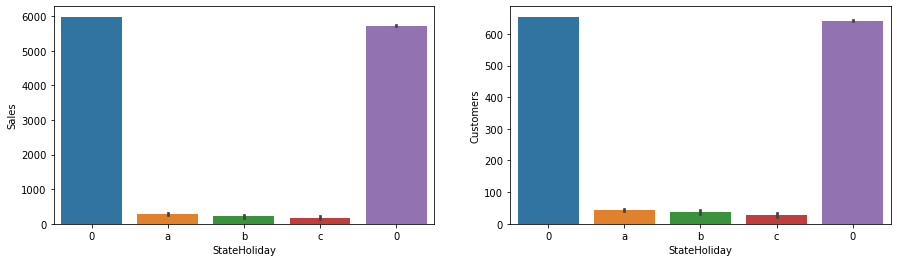

In [320]:
# State Holiday
#train_df['StateHoliday'] =train_df['StateHoliday'].map({0:0,'0':0,'a':1,'b':1,'c':1})

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday',y='Sales',data=train_df,ax=ax1)
sns.barplot(x='StateHoliday',y='Customers',data=train_df,ax=ax2)

<AxesSubplot:xlabel='SchoolHoliday', ylabel='Customers'>

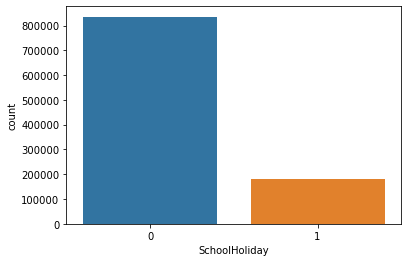

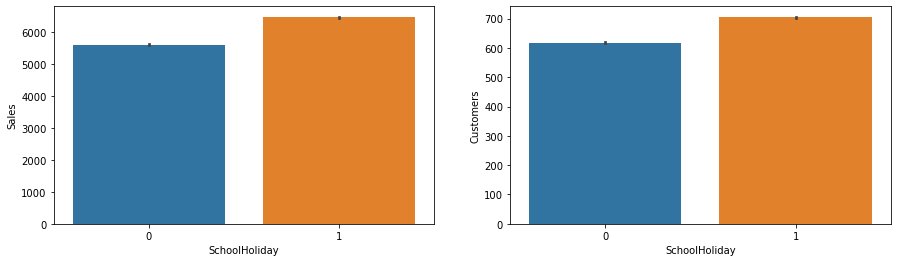

In [321]:
#School Holiday
sns.countplot(x='SchoolHoliday',data=train_df)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=train_df, ax=ax1)
sns.barplot(x='SchoolHoliday', y='Customers', data=train_df, ax=ax2)

- **Observations**
    - We Observe that Most of Stores remains closed during State Holidays.
    - Also, we see that Number of Stores Opened during School Holiday is more than that of State Holiday.
    - Another important thing to note that, stores which were opened during the school holiday had more sales than normal

In [322]:
# Joining Store Data and trian Data
train_store_df = pd.merge(train_df,store_df,how='left',on='Store')
train_store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,WeekofYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,31,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,31,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Store-Type


In [323]:
train_store_df.groupby("StoreType")['Customers','Sales'].describe()

Customers                                                        \
              count         mean         std  min     25%     50%     75%   
StoreType                                                                   
a          551627.0   659.034880  462.930320  0.0   414.0   647.0   890.0   
b           15830.0  1987.720846  940.088627  0.0  1228.0  1820.0  2732.0   
c          136840.0   673.265894  430.708776  0.0   455.0   682.0   924.0   
d          312912.0   501.434892  292.301770  0.0   375.0   530.0   681.0   

                      Sales                                                  \
              max     count          mean          std  min     25%     50%   
StoreType                                                                     
a          7388.0  551627.0   5738.179710  3964.028134  0.0  3508.0  5618.0   
b          5494.0   15830.0  10058.837334  5280.525506  0.0  6227.0  9025.5   
c          3096.0  136840.0   5723.629246  3721.700886  0.0  3789.0  5766.0   
d          2239.0  312912.0   5641.819243  3473.393781  0.0  3986.0  5826.0   

                              
                75%      max  
StoreType                     
a           7860.00  41551.0  
b          13082.75  38722.0  
c           7849.00  31448.0  
d           7691.00  38037.0

In [324]:
train_store_df.groupby("StoreType")['Customers','Sales'].sum().sort_values("Sales",ascending=True)

,Customers,Sales
StoreType,,
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943
a,363541434,3165334859


- **Observation**
    - Store Type B has the Highest Average Sales 
    - Store Type A has the Highest Number of Customers and sales.
    - Sales:      Store A > Store D > Store c > Store B
    - Customer:   Store A > Store D > Store c > Store B
    - This means there is postive correlation between Customers and Sales

# Promo

In [325]:
store_df_1 = train_store_df[train_store_df.Store == 1]
store_df_1.sort_values('Date',inplace=True)
store_df_1[['DayOfWeek','Sales','Customers','Promo','Open']].head(50)

,DayOfWeek,Sales,Customers,Promo,Open
1016095,2,0,0,0,0
1014980,3,5530,668,0,1
1013865,4,4327,578,0,1
1012750,5,4486,619,0,1
1011635,6,4997,635,0,1
1010520,7,0,0,0,0
1009405,1,7176,785,1,1
1008290,2,5580,654,1,1
1007175,3,5471,626,1,1
1006060,4,4892,615,1,1


In [326]:
store_df_2= train_store_df[train_store_df['Store']==2]

store_df_2.sort_values('Date', inplace=True)
store_df_2[['DayOfWeek','Sales','Customers','Promo','Open']].head(50)

,DayOfWeek,Sales,Customers,Promo,Open
1016096,2,0,0,0,0
1014981,3,4422,650,0,1
1013866,4,4159,555,0,1
1012751,5,4484,574,0,1
1011636,6,2342,324,0,1
1010521,7,0,0,0,0
1009406,1,6775,763,1,1
1008291,2,6318,685,1,1
1007176,3,6763,785,1,1
1006061,4,5618,637,1,1


In [327]:
store_df_2[store_df_2['Month']>3][['Date','DayOfWeek','Sales','Customers','Promo','Open']].head(50)

,Date,DayOfWeek,Sales,Customers,Promo,Open
915746,2013-04-01,1,0,0,0,0
914631,2013-04-02,2,3643,507,0,1
913516,2013-04-03,3,4250,600,0,1
912401,2013-04-04,4,4114,542,0,1
911286,2013-04-05,5,3872,470,0,1
910171,2013-04-06,6,2461,315,0,1
909056,2013-04-07,7,0,0,0,0
907941,2013-04-08,1,6696,732,1,1
906826,2013-04-09,2,6574,667,1,1
905711,2013-04-10,3,6520,780,1,1


- **Observation**
    - Here we can observe that Promo happens for 5 days and it happens twice in a month.
    - We can also observe that whenever Promo happens there is increase in Sales.
    - We can expect that atleast there will Promo of 10 days in a month with more than regular Sales

## Checking Seasonality - Fourier Transform 

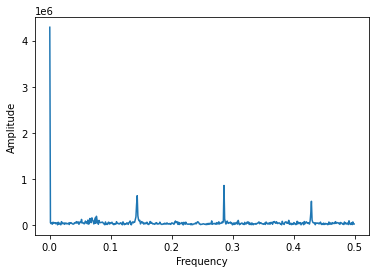

In [328]:
# Get store Type 'A'
store_df_14_sales = train_store_df[train_store_df['Store']==14]['Sales']

## getting peaks reference: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
Y = np.fft.fft(store_df_14_sales.values)

freq = np.fft.fftfreq(len(Y),1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)],np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

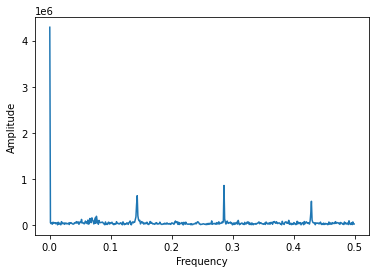

In [329]:
# Get store Type 'B'
store_df_259_sales = train_store_df[train_store_df['Store']==259]['Sales']

## getting peaks reference: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
Y = np.fft.fft(store_df_14_sales.values)

freq = np.fft.fftfreq(len(Y),1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)],np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

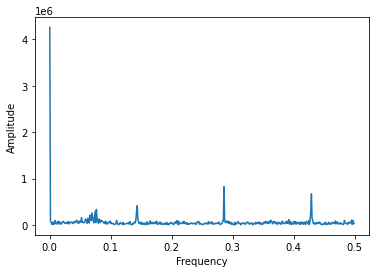

In [330]:
# Get store Type 'c'
store_df_21_sales = train_store_df[train_store_df['Store']==21]['Sales']

## getting peaks reference: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
Y = np.fft.fft(store_df_21_sales.values)

freq = np.fft.fftfreq(len(Y),1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)],np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

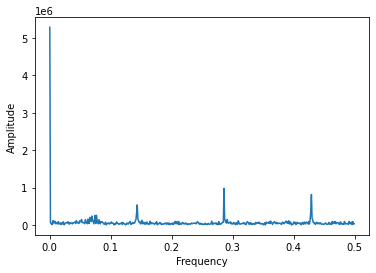

In [331]:
# Get store Type 'd'
store_df_111_sales = train_store_df[train_store_df['Store']==111]['Sales']

## getting peaks reference: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
Y = np.fft.fft(store_df_111_sales.values)

freq = np.fft.fftfreq(len(Y),1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)],np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

- **Observation**
    - In the above graphs, we can see that there are some spikes at particular frequencies.This indicates that there is a seasonality compenent in store sales data

# Competition Open Since Year/Month

In [332]:
percent_year = (store_df[store_df['CompetitionOpenSinceYear'].isnull()].shape[0]/len(store_df))*100
percent_month= (store_df[store_df['CompetitionOpenSinceYear'].isnull()].shape[0]/len(store_df))*100

print(f'missing values % in Competition Open Since Year feature is = {round(percent_year,3)}%.')
print(f'missing values % in Competition Open Since Month feature is = {round(percent_month,3)}%.')

missing values % in Competition Open Since Year feature is = 31.749%.
missing values % in Competition Open Since Month feature is = 31.749%.


In [333]:
store_df[store_df['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


<AxesSubplot:xlabel='CompetitionOpenSinceYear', ylabel='Density'>

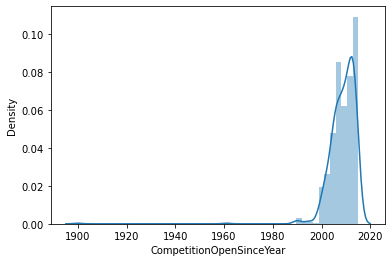

In [334]:
sns.distplot(store_df['CompetitionOpenSinceYear'])

In [335]:
year_median = store_df['CompetitionOpenSinceYear'].median()
print("Most of the Store have opened in the year for competition : ",year_median)

Most of the Store have opened in the year for competition :  2010.0


<AxesSubplot:xlabel='CompetitionOpenSinceMonth', ylabel='Density'>

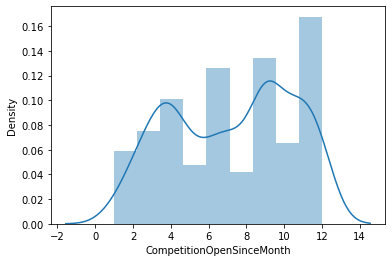

In [336]:
sns.distplot(store_df['CompetitionOpenSinceMonth'])

In [337]:
month_median = store_df['CompetitionOpenSinceMonth'].median()
print(f'Most of stores have their competition opened in the month {month_median}.')

Most of stores have their competition opened in the month 8.0.


# Competition Distance

In [338]:
percent_distance = (store_df[store_df['CompetitionOpenSinceMonth'].isnull()].shape[0]/len(store_df))*100
print("% of missing values in Competition Distance is :",round(percent_distance,2),"%")

% of missing values in Competition Distance is : 31.75 %


In [339]:
store_df[store_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Text(0.5, 0, 'Competition Distance')

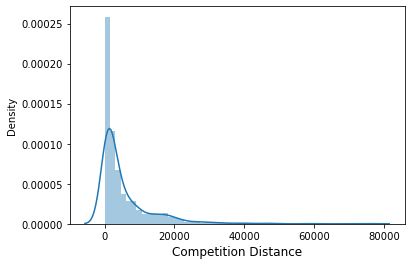

In [340]:
sns.distplot(store_df['CompetitionDistance'])
plt.xlabel("Competition Distance",fontsize=12)

In this figure we can see that most of the stores have their competition within 4km range

- **Observation**
    - missing values in CompetitionOpenYear/Month doesn't indicate that there's no competition near the store as the value of CompetitionDistance is not null where the CompetitionOpenYear/Month is null.

    - Thus they are not dependent on each other and absence of one value doesn't indicate that other will be absent.

# Promo2 / Promo2SinceWeek

In [341]:
store_df[store_df.Promo2 == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


Stores which are not particoipated in Promo2 have NaN Values in Promo2SinceWeek/Year and PromoInterval

<AxesSubplot:xlabel='Promo2', ylabel='Sales'>

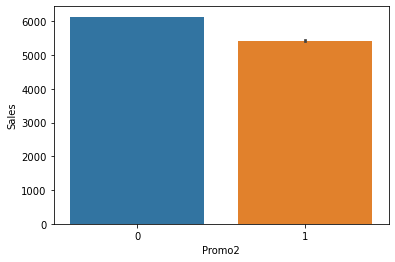

In [342]:
sns.barplot(train_store_df['Promo2'],train_store_df["Sales"])

In [343]:
promo2_sales_0= train_store_df[train_store_df.Promo2==0]['Sales'].sum()
promo2_sales_1 = train_store_df[train_store_df.Promo2==1]['Sales'].sum()

print("No Promo2 sales : ",promo2_sales_0)
print("Promo2 Sales : ",promo2_sales_1)

No Promo2 sales :  3111542628
Promo2 Sales :  2761637995


- **Observation**
    - we can observe that Promo2 has no affect on Sales. which means Stores which did not  participated in Promo2  has greater sales.
    - Store which did not participated in Promo2 have 'NAN' values in Promo2SinceWeek/Year and PromoInterval. We can replace it with -1.
    - -1 will indictae that particular store has not participated in Promo2

# Findings in EDA

- Store Type A has Highest Sales and Highest Customers inflow

- Sales and Customers are highy Correlated to each other

- Most Stores are Closed omn Sundays and State Holidays

- Stores which are open on School Holidays have high sales than normal day  Sales

- Promotion leads to increase in Sales for all type of Stores; The Promotion happens for 5 days, twice very month

- Sales tends to peak in Christmas week, this is due to fact that people buy more beauty products for festival celebration

- After performing fourier transform on sales, we found that there is some seasonality component in Sales Data

- Absence of values in feature CompetitionOpenSinceYear/Month doesn't indicate the absence of competition as CompetitionDistance values are not null where the other two values are null.